In [1]:
from tf_activation.models import mnist_cff as mnist_model

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import itertools
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
GRAPH_LOC = '../logdir/data/graphs'
SAVE_PATH = '../logdir/models'
RESULT_PATH = '../logdir/data/experiments/cluster_mnist'
ADV_TYPE = 'carlini_attacks_targeted5020'
ADV_SET = 'adversaries/' + ADV_TYPE + '/100'
ADV_IMAGES = '../logdir/adversaries/' + ADV_TYPE
model = 'mnist_cff50.ckpt'
graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f)) and int(f[2:f.find('.')]) < 50]
adv_graphmls = [f for f in listdir(join(GRAPH_LOC, ADV_SET)) if isfile(join(GRAPH_LOC, ADV_SET, f))]
MAX_STEPS = 50

def get_matchings(x_list, y_list):
    ret = []
    for x in x_list:
        if y_list.isin([x]).any():
            ret.append(x)
    return ret

def average_sim(df):
    s = 0
    for col in df.columns:
        s += df[col].dropna().shape[0]
    return s/len(df.columns)

In [3]:
df = []
files = []
with tf.device('/cpu:0'):
        # Create the model
        x = tf.placeholder(tf.float32, [None, 784])

        # Define loss and optimizer
        y_ = tf.placeholder(tf.float32, [None, 10])

        # Build the graph for the deep net
        net, keep_prob = mnist_model.deepnn(x)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        
with tf.Session() as sess:
    
    saver.restore(sess, os.path.join(SAVE_PATH, model))
    
    for f in graphmls:
        print(f)
        files.append(f)
        i = int(f[2:f.find('.')])
        col = {}
        g1 = nx.read_graphml(join(GRAPH_LOC, f)).to_undirected()
        g = nx.Graph()
        for e1, e2, data in g1.edges(data=True):
            g.add_edge(e1, e2, weight=data['weight'])
        col['number_connected_components'] = nx.number_connected_components(g)
        col['average_node_connectivity'] = nx.average_node_connectivity(g)
        
        test_inputs = np.stack((mnist.train.images[i], mnist.train.images[i]))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        col['adversary'] = False
        col['predicted_class'] = np.argmax(y_conv)
        col['file'] = f
        col['correct'] = np.argmax(mnist.train.labels[i])
        
        df.append(col)
    steps = 0
    for f in adv_graphmls:
        print(f)
        files.append(f)
        i = int(f[4:f.find('.')])
        col = {}
        g1 = nx.read_graphml(join(GRAPH_LOC, ADV_SET, f)).to_undirected()
        g = nx.Graph()
        for e1, e2, data in g1.edges(data=True):
            g.add_edge(e1, e2, weight=data['weight'])
        col['number_connected_components'] = nx.number_connected_components(g)
        col['average_node_connectivity'] = nx.average_node_connectivity(g)
        
        adv_im = np.genfromtxt(join(ADV_IMAGES, f[:f.find('.')] + '.csv'), delimiter=',')
        
        test_inputs = np.stack((adv_im, adv_im))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        col['adversary'] = True
        col['predicted_class'] = np.argmax(y_conv)
        col['file'] = f
        col['correct'] = np.argmax(mnist.train.labels[i])
        
        df.append(col)
        
        steps += 1
        if steps > MAX_STEPS:
            break
        
df = pd.DataFrame(df)

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff50.ckpt
4_2.graphml
1_12.graphml
7_49.graphml
9_45.graphml
8_9.graphml
2_13.graphml
6_40.graphml
6_39.graphml
0_15.graphml
7_14.graphml
4_47.graphml
3_31.graphml
1_23.graphml
9_17.graphml
8_34.graphml
5_28.graphml
6_3.graphml
9_8.graphml
8_29.graphml
0_7.graphml
6_26.graphml
3_1.graphml
2_16.graphml
6_37.graphml
1_20.graphml
4_46.graphml
9_24.graphml
0_10.graphml
8_5.graphml
7_25.graphml
1_6.graphml
6_21.graphml
9_44.graphml
8_30.graphml
0_48.graphml
7_22.graphml
8_43.graphml
4_38.graphml
7_0.graphml
4_33.graphml
5_27.graphml
3_41.graphml
3_36.graphml
8_42.graphml
7_35.graphml
3_11.graphml
0_19.graphml
1_4.graphml
6_18.graphml
4_32.graphml
0_2_3.graphml
9_0_7.graphml
3_4_30.graphml
7_2_0.graphml
7_0_26.graphml
1_8_5.graphml
1_0_5.graphml
5_3_45.graphml
2_4_38.graphml
7_2_26.graphml
1_3_46.graphml
0_4_28.graphml
1_3_40.graphml
5_0_23.graphml
5_7_23.graphml
2_3_35.graphml
3_0_32.graphml
1_4_40.graphml
6_0_21.graphml
4_8_

In [4]:
df.head()

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
0,1.0,False,0.130179,4,1.468234e-02,4_2.graphml,8,4,0.510284
1,1.0,False,0.647177,1,0.000000e+00,1_12.graphml,2,1,0.778228
2,1.0,False,0.253659,7,0.000000e+00,7_49.graphml,5,7,0.697406
3,1.0,False,0.285792,9,4.768370e-07,9_45.graphml,5,9,0.703297
4,1.0,False,0.121139,8,0.000000e+00,8_9.graphml,10,8,0.675188


In [5]:
df.sort_values(by='average_node_connectivity', axis=0, ascending=False)

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
49,1.0,False,1.785563,4,0.000000e+00,4_32.graphml,1,4,0.600658
95,0.0,True,1.255599,6,1.778037e+01,1_5_39.graphml,7,5,0.017602
8,1.0,False,1.177047,0,0.000000e+00,0_15.graphml,1,0,0.850613
78,0.0,True,1.102407,8,1.889346e+01,1_3_29.graphml,1,3,-0.038327
62,0.0,True,1.035935,6,2.628764e+01,1_3_40.graphml,4,3,-0.310133
55,1.0,True,1.024837,8,2.026556e-06,1_8_5.graphml,6,8,0.807968
96,0.0,True,0.988125,6,2.091074e+01,1_9_40.graphml,7,9,-0.267578
83,0.0,True,0.986702,8,1.635433e+01,1_2_5.graphml,8,2,-0.001933
60,0.0,True,0.962813,4,2.350221e+01,1_3_46.graphml,4,3,-0.230798
67,0.0,True,0.944101,6,1.848178e+01,1_4_40.graphml,5,4,-0.084651


In [17]:
df.to_pickle('../logdir/data/experiments/subgraph_algo_analysis_targeted5020.pkl')

In [7]:
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.externals import joblib
def regress(X, y, xlab, ylab, color_vals='b'):

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))

    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs

    ax.scatter(X, y,  color=color_vals)
#     ax.plot(X, regr.predict(X), color='silver', linewidth=3)
#     ax.set_xlim(X_min, X_max)
#     ax.set_ylim(y_min, y_max)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()

('Coefficients: ', array([[ 8.33244691]]))
Mean squared error: 180.29
Variance score: -7.90
R^2: -7.90


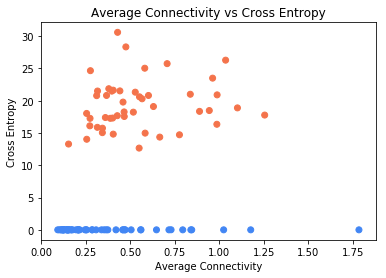

In [8]:
color_vals = ['#f4734b' if a == 0.0 else '#4286f4' for a in df['accuracy']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['cross_entropy']), 'Average Connectivity', 'Cross Entropy', color_vals=color_vals)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb77c3e0f10>]], dtype=object)

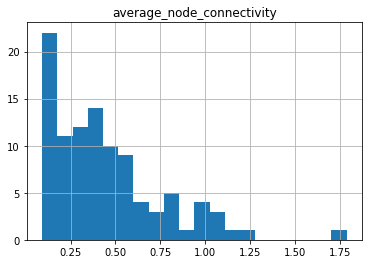

In [22]:
df.hist(column='average_node_connectivity', bins=20)

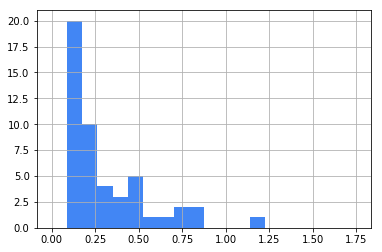

In [51]:
df[~df['adversary']]['average_node_connectivity'].hist(bins=20, range=[0,1.75], color='#4286f4')

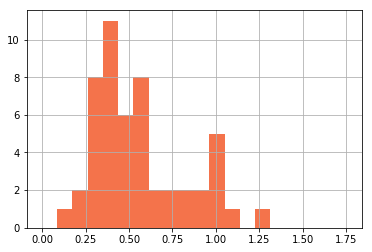

In [50]:
df[df['adversary']]['average_node_connectivity'].hist(bins=20, range=[0,1.75], color='#f4734b')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7f8504b50>]], dtype=object)

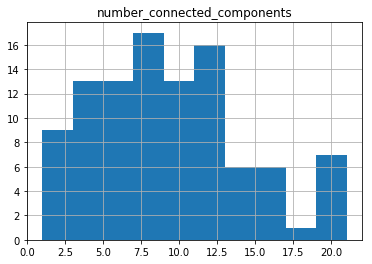

In [23]:
df.hist(column='number_connected_components')

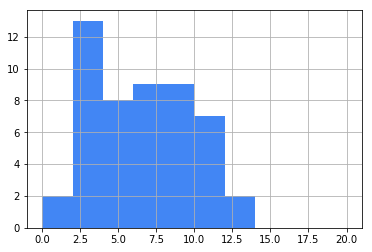

In [52]:
df[~df['adversary']]['number_connected_components'].hist(range=[0,20], color='#4286f4')

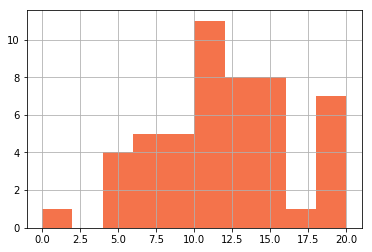

In [53]:
df[df['adversary']]['number_connected_components'].hist(range=[0,20],  color='#f4734b')

In [34]:
df[df['accuracy'] == 0.0]

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
50,0.0,True,0.366339,6,20.818106,0_2_3.graphml,12,2,-0.235025
52,0.0,True,0.404074,8,14.826588,3_4_30.graphml,14,4,-0.013249
53,0.0,True,0.583362,7,14.983345,7_2_0.graphml,15,2,0.126197
54,0.0,True,0.889264,6,18.355047,7_0_26.graphml,20,0,-0.137215
56,0.0,True,0.466067,8,17.560053,1_0_5.graphml,18,0,-0.077544
57,0.0,True,0.441491,9,21.526909,5_3_45.graphml,9,3,-0.065033
59,0.0,True,0.517120,6,18.231712,7_2_26.graphml,11,2,-0.146975
60,0.0,True,0.962813,4,23.502213,1_3_46.graphml,4,3,-0.230798
61,0.0,True,0.343455,5,15.748920,0_4_28.graphml,11,4,-0.232023
62,0.0,True,1.035935,6,26.287640,1_3_40.graphml,4,3,-0.310133


In [36]:
df[df['adversary']]

,accuracy,adversary,average_node_connectivity,correct,cross_entropy,file,number_connected_components,predicted_class,y_conv
50,0.0,True,0.366339,6,2.081811e+01,0_2_3.graphml,12,2,-0.235025
51,1.0,True,0.560058,0,2.980228e-06,9_0_7.graphml,12,0,0.789291
52,0.0,True,0.404074,8,1.482659e+01,3_4_30.graphml,14,4,-0.013249
53,0.0,True,0.583362,7,1.498335e+01,7_2_0.graphml,15,2,0.126197
54,0.0,True,0.889264,6,1.835505e+01,7_0_26.graphml,20,0,-0.137215
55,1.0,True,1.024837,8,2.026556e-06,1_8_5.graphml,6,8,0.807968
56,0.0,True,0.466067,8,1.756005e+01,1_0_5.graphml,18,0,-0.077544
57,0.0,True,0.441491,9,2.152691e+01,5_3_45.graphml,9,3,-0.065033
58,1.0,True,0.794759,4,7.152555e-07,2_4_38.graphml,12,4,0.743071
59,0.0,True,0.517120,6,1.823171e+01,7_2_26.graphml,11,2,-0.146975


('Coefficients: ', array([[-0.32881678]]))
Mean squared error: 0.37
Variance score: -12.55
R^2: -12.55


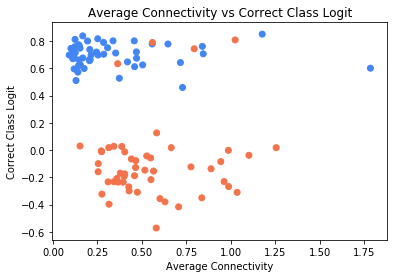

In [48]:
color_vals = ['#f4734b' if a else '#4286f4' for a in df['adversary']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['y_conv']), 'Average Connectivity', 'Correct Class Logit', color_vals=color_vals)

('Coefficients: ', array([[ 8.33244691]]))
Mean squared error: 180.29
Variance score: -7.90
R^2: -7.90


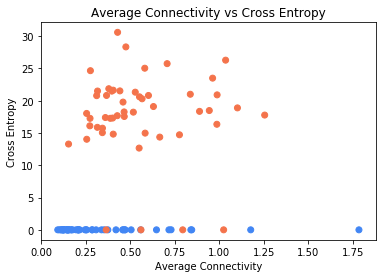

In [49]:
color_vals = ['#f4734b' if a else '#4286f4' for a in df['adversary']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['cross_entropy']), 'Average Connectivity', 'Cross Entropy', color_vals=color_vals)

In [ ]:
color_vals = ['#f4734b' if a else '#4286f4' for a in df['adversary']]
regress(df.as_matrix(columns=['average_node_connectivity']), df.as_matrix(columns=['cross_entropy']), 'Average Connectivity', 'Cross Entropy', color_vals=color_vals)